# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

### Описание проекта

Данный проект направлен на разработку модели машинного обучения для прогнозирования оттока (churn) клиентов сервиса доставки кофе Happy Beans Coffee. Модель предназначена для выявления клиентов с высокой вероятностью прекращения использования сервиса в следующем месяце на основе их поведенческих, транзакционных и демографических данных.

### Актуальность
В условиях высокой конкуренции на рынке доставки кофе удержание существующих клиентов критически важно, так как обходится в 5–7 раз дешевле, чем привлечение новых. Ежемесячная потеря 10% клиентской базы напрямую снижает выручку и приводит к неэффективному расходованию маркетингового бюджета. Модель позволит:
- точечно работать с клиентами, готовыми уйти, с помощью персональных предложений (скидки, промокоды),
- оптимизировать бюджет на маркетинг и удержание,
- повысить прогнозируемость доходов и понимание ценности клиентской базы.

## Постановка задачи машинного обучения

Перед нами стоит задача бинарной классификации, так как необходимо предсказать принадлежность клиента к одному из двух классов:
*   *0 (Лояльный клиент)* — клиент продолжит пользоваться сервисом.
*   *1 (Клиент может уйти / Отток)* — клиент прекратит пользоваться сервисом в следующем месяце.
Целевой переменной является столбец `churn`.

Для оценки качества модели, учитывая бизнес-контекст и вероятный дисбаланс классов, будем использовать ключевые метрики:
1.  *Precision (Точность)* — доля клиентов, предсказанных как «уходящие», которые действительно уйдут. Минимизирует затраты на ошибочные акции удержания для лояльных клиентов.
2.  *Recall (Полнота)* — долю всех реально уходящих клиентов, которых модель смогла обнаружить. Минимизирует риск «проглядеть» уходящих клиентов.
3.  *F1-score (F1-мера)* — гармоническое среднее Precision и Recall, «золотая середина» для поиска баланса между охватом и точностью.
4.  *PR AUC (Precision-Recall AUC)* — площадь под кривой Precision-Recall. Ключевая агрегированная метрика для задач с дисбалансом классов, фокусируется на качестве предсказания класса «отток».

**Критерии успешности проекта**:
- Модель должна быть *линейной* (например, `LogisticRegression`) для простоты интерпретации бизнесом.
- Достигнуть максимизации *PR AU** и баланса **F1-score** на валидационной и тестовой выборках.
- Обеспечить *воспроизводимость* результатов (фиксация `random_state`).
- Решение должно быть готово к промышленной эксплуатации: сохранен не только итоговый классификатор, но и весь **пайплайн предобработки** данных (используя `joblib`).

Проект считается успешным, если модель позволяет выявить значительную долю уходящих клиентов с приемлемым уровнем ложных срабатываний, что дает бизнесу возможность эффективно планировать и проводить кампании по удержанию.

### План работы

1.  Загрузка данных и подготовка среды.
2.  Исследовательский анализ данных (EDA).
3.  Предобработка данных (обработка пропусков, кодирование категориальных признаков, масштабирование).
4.  Обучение и оценка базовой модели (`DummyClassifier`).
5.  Создание и отбор новых признаков.
6.  Обучение и валидация моделей (с кросс-валидацией).
7.  Подбор гиперпараметров для лучшей модели.
8.  Финальная оценка модели на тестовой выборке.
9.  Интерпретация модели (анализ важности признаков).
10. Подготовка функции/пайплайна для прогнозирования оттока новых клиентов.
11. Сохранение артефактов (модель, пайплайн, энкодеры).
12. Общие выводы и бизнес-рекомендации.

## Подключение и настройка библиотек
Импортируем все библиотеки, которые понадобятся для проекта.

In [1]:
# Импортируем библиотеки для работы с датафреймами и математическими операциями
import numpy as np
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

# Загружаем библиотеки для машинного обучения
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder

# Импортируем библиотеку для сохранения модели
import joblib

Для воспроизводимости результатов создадим глобальную переменную `RANDOM_STATE` и зафиксируем версии пакетов, которые использовались в проекте, в отдельный файл `requirements.txt`.

In [2]:
# Фиксируем random_state для воспроизводимости результатов
RANDOM_STATE = 42

Файл `requirements.txt` содержит следующую информацию:

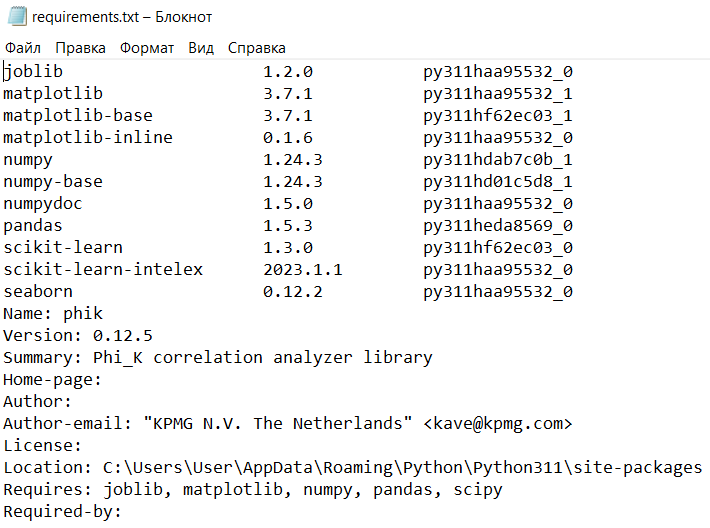

## 1. Загрузка датасета

В работе используются данные из файла `coffee_churn_dataset.csv`. Датасет имеет следующую информацию:

- `user_id` — идентификатор пользователя.
- `days_since_last_order` — количество дней, прошедших с последнего заказа.
- `order_frequency_month` — среднее число заказов в месяц.
- `order_frequency_week` — среднее число заказов в неделю.
- `avg_order_value` — средний чек, в рублях.
- `median_order_value` — медианный чек, в рублях.
- `total_spent_last_month` — сумма заказов за последний месяц.
- `total_spent_last_week` — сумма заказов за последнюю неделю.
- `discount_usage_rate` — доля заказов со скидкой за последний месяц.
- `last_coffee_type` — сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `preferred_roast` — предпочитаемый тип обжарки.
- `milk_preference` — предпочитаемый тип молока.
- `seasonal_menu_tried` — отметка о том, пробовал ли пользователь новейшее сезонное меню.
- `coffee_bean_origin` — страна происхождения зерна.
- `last_drink_size` — размер последнего заказа, совершённого на момент сбора данных.
- `subscription_status` — тип подписки пользователя.
- `app_opens_per_week` — сколько раз за неделю пользователь в среднем открывал приложение доставки кофе.
- `notifications_enabled` — включены ли у пользователя уведомления.
- `review_rating_last_10` — средняя оценка последних на момент сбора данных десяти заказов клиента.
- `review_rating_last_1` — оценка последнего на момент сбора данных заказа клиента.
- `app_crashes_last_month` — сколько раз приложение зависало за последний месяц.
- `seasons` — текущее время года.
- `days_since_last_promo` — сколько дней прошло с последнего использования акции или промокода.
- `phone_type` — тип устройства, с которого пользователь чаще всего совершал покупки.
- `coffee_preference_change` — менялись ли вкусовые предпочтения пользователя.
- `geo_id` — идентификатор региона пользователя.
- `churn` — перестал ли пользователь пользоваться сервисом.

Загрузим данные из CSV-файла, используя метод read_csv, установив значения для параметров sep=',' и decimal='.'.

In [3]:
# Выгружаем данные в переменную df
df = pd.read_csv('https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv', sep=',', decimal='.')

In [4]:
# Выводим первые строки датафрейма
df.head()

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1


In [5]:
# Выводим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

По полученным значениям можно сказать, что загрузка файла прошла успешно. Столбцы отображены в удобном, понятном формате и соответствуют заявленным. Значения также загружены правильно, но требуют ряд изменений. Для этого проведём более подробный анализ данных.

Стоит создать копию датасета, чтобы сранивать обработанные данные с исходными.

In [6]:
# Создаем копию датасета
temp = df.copy() 
len(temp)

10450

## 2. Первичный анализ данных

### 2.1. Общая информация о данных

Данные содержат информацию о 10 450 клиентах компании Happy Beans Coffee, собранную за последние 4 недели. Каждая строка представляет одного уникального клиента с 27 различными характеристиками. Из данных видно, что компания отслеживает разнообразные аспекты поведения клиентов: от частоты и стоимости заказов до предпочтений в выборе кофе и активности в мобильном приложении. Примечательно наличие как количественных показателей (средний чек, количество открытий приложения), так и качественных характеристик (предпочитаемый сорт кофе, тип устройства). Особый интерес представляют признаки, связанные с взаимодействием клиента с сервисом: уведомления, оценка заказов и даже количество сбоев приложения. Все эти данные формируют многомерный портрет клиента, который позволяет анализировать закономерности оттока. 

Датасет содержит смешанные типы данных: числовые (16 признаков типа float64 и 1 признак int64 — целевая переменная churn) и категориальные (10 признаков типа object). Такое разнообразие типов требует разных подходов к предобработке. Числовые признаки в основном представляют собой непрерывные величины, которые потребуют масштабирования, особенно для линейных моделей, поскольку признаки имеют разные диапазоны значений — например, средний чек может измеряться сотнями рублей, а частота заказов в неделю обычно меньше 10. Также важно проверить распределение числовых признаков на наличие выбросов, которые могут негативно повлиять на работу модели. Категориальные признаки также требуют обрабоботки. Для них подходит способы One-Hot Encoding или Target Encoding (усреднение по целевому признаку). Дополнительно можно уменьшить размерность некоторых данных, чтобы сократить объем используемой памяти без потери точности. Общий объём данных составляет 2.2+ МВ.

Особое внимание требует обработка пропущенных значений, которые присутствуют практически во всех колонках . Для числовых признаков разумной стратегией будет замена медианой, а для категориальных - новое значение - заглушка (например "-1" или "unknown").

При преобразовании данных важно помнить о будущей эксплуатации модели. Все преобразования должны быть сохранены в пайплайне с помощью sklearn Pipeline, чтобы при поступлении новых данных они обрабатывались идентично. Это гарантирует согласованность между этапом обучения и эксплуатации.

### 2.2. Целевая переменная

Целевая переменная `churn` является бинарной (0 или 1), что соответствует задаче бинарной классификации "Клиент лояльный" (0) или "Клиент может уйти" (1). Критически важным аспектом является распределение этой переменной. Учитывая бизнес-контекст (компания теряет 10% клиентской базы ежемесячно), можно ожидать дисбаланса классов. Если отток составляет 10%, то соотношение классов будет примерно 90% лояльных клиентов к 10% уходящих. Такой сильный дисбаланс существенно влияет на выбор метрик и стратегию обучения модели — стандартная accuracy будет неинформативной, так как модель, всегда предсказывающая "лояльный", достигнет 90% точности, но окажется бесполезной для бизнеса. Поэтому необходимы метрики, чувствительные к меньшинству класса: precision, recall, F1-score и особенно PR-AUC.

Распределение целевой переменной:
0    0.939809
1    0.060191
Name: churn, dtype: float64


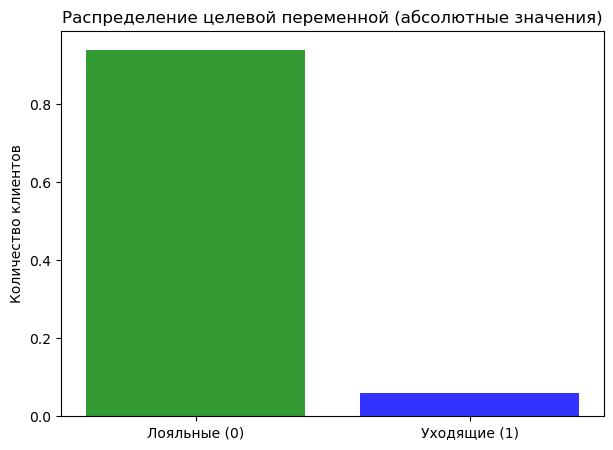

In [7]:
# Анализ распределения churn
churn_distribution = df['churn'].value_counts(normalize=True)
print(f"Распределение целевой переменной:\n{churn_distribution}")

plt.figure(figsize=(7, 5))
bars = plt.bar(['Лояльные (0)', 'Уходящие (1)'], 
               churn_distribution,
               color=['green', 'blue'], alpha=0.8)
plt.title('Распределение целевой переменной (абсолютные значения)')
plt.ylabel('Количество клиентов')
plt.show()

По диаграмме видно существенное преобладание лояльных клиентов. Пропуски отсутствуют, а данные содержат значения "0" и "1".

### 2.3. Признаки

Признаки в датасете можно разделить на несколько логических групп. Первая группа — признаки активности: `days_since_last_order` (дней с последнего заказа), `order_frequency_month/week` (частота заказов), `total_spent_last_month/week` (суммы трат). Эти признаки непосредственно отражают текущую вовлеченность клиента. Вторая группа — финансовые показатели: `avg_order_value`, `median_order_value`, `discount_usage_rate`. Третья группа — предпочтения: `last_coffee_type`, `preferred_roast`, `milk_preference`, `coffee_bean_origin`, `last_drink_size`. Четвертая группа — взаимодействие с приложением: `app_opens_per_week`, `notifications_enabled`, `app_crashes_last_month`. Пятая группа — обратная связь: `review_rating_last_10`, `review_rating_last_1`. Также есть контекстные признаки: `seasons`, `phone_type`, `geo_location`.

При анализе важности признаков сразу выделяется `user_id` — это уникальный идентификатор клиента, который не несет предсказательной силы для модели. Его использование в обучении привело бы к переобучению, так как модель могла бы запомнить конкретных клиентов вместо выявления общих закономерностей. Этот признак следует удалить на этапе подготовки данных. Признак `geo_location` (идентификатор региона) требует дополнительного анализа: если у компании нет возможности проводить географически-ориентированные акции по удержанию или если регионов слишком много с малым количеством клиентов в каждом, этот признак также может оказаться малоинформативным. Признаки `avg_order_value` и `median_order_value` описывают типичный размер чека. Вероятно, сильно коррелированы между собой, поэтому можно оставить один из них, предпочтительно медиану, как более устойчивую к выбросам.

Датасет хорошо структурирован и содержит релевантные для задачи прогнозирования оттока признаки, что позволяет ожидать построения работоспособной модели после грамотной предобработки.

Перед тем как приступить к удалению столбцов, проверим их на явные и неявные дубликаты. Частичные дубликаты проверим по полю `user_id`.

In [8]:
# Проверка полных дубликатов
dup = df.duplicated().sum()
print("Полные дубликаты:", dup)
print("Процент дубликатов от общего числа записей:", round(dup / len(df) * 100, 2), "%")

Полные дубликаты: 0
Процент дубликатов от общего числа записей: 0.0 %


In [9]:
# Проверка дубликатов по ключевым полям (частичные дубликаты)
print("Дубликаты user_id:", df['user_id'].duplicated().sum())

Дубликаты user_id: 0


Дубликатов в датафрейме не обнаружено. Теперь можно удалить ненужные признаки.

In [10]:
# Удалим признаки user_id и geo_location
df = df.drop(['user_id', 'geo_location'], axis=1)

In [11]:
# Проверим корреляцию между признаками через phik_matrix()
phik_corr = df[['avg_order_value', 'median_order_value']].phik_matrix()

print("Матрица корреляции phik между avg_order_value и median_order_value:")
print(phik_corr)

interval columns not set, guessing: ['avg_order_value', 'median_order_value']
Матрица корреляции phik между avg_order_value и median_order_value:
                    avg_order_value  median_order_value
avg_order_value            1.000000            0.890398
median_order_value         0.890398            1.000000


Так как корреляция между `avg_order_value`и `median_order_value` 0.89 очень высокая, можно удалить столбец `avg_order_value`.

In [12]:
df = df.drop('avg_order_value', axis=1)

### 2.4. Обработка пропущенных значений

In [13]:
# Copyright (c) 2025 Олег Мазуренко
# All rights reserved


def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    Параметры:   tmp0 (pd.DataFrame): Исходный DataFrame для анализа
    Возвращает:  Styler или строку: Объект Styler с подсветкой или сообщение об отсутствии пропусков
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean().round(4)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
days_since_last_order,945,0.090400
order_frequency_month,600,0.057400
order_frequency_week,388,0.037100
median_order_value,831,0.079500
total_spent_last_month,294,0.028100
total_spent_last_week,944,0.090300
discount_usage_rate,397,0.038000
last_coffee_type,258,0.024700
preferred_roast,116,0.011100
milk_preference,668,0.063900


Пропуски в данных нужно обрабатывать, потому что большинство алгоритмов машинного обучения не умеют работать с пустыми значениями — они просто вызовут ошибку при обучении модели. Даже если алгоритм не сломается, пропуски могут исказить результаты: например, если просто удалить строки с пропусками, мы можем потерять важных клиентов или сместить распределение данных.

#### Границы пропусков

Пропуски в данных распределены в диапазоне от 1.1% до 9.5%, что свидетельствует о систематическом, а не случайном характере отсутствующих значений. Минимальный процент пропусков (1.1%) наблюдается у признака `preferred_roast` (предпочитаемый тип обжарки), что может указывать на высокую заполняемость данных о базовых предпочтениях клиентов. Максимальные значения пропусков (9.0-9.5%) зафиксированы у ключевых поведенческих признаков: `days_since_last_order` (9.0%), `total_spent_last_week` (9.0%), `subscription_status` (9.0%) и `seasonal_menu_tried` (9.5%). Большинство признаков имеют уровень пропусков в диапазоне 5-10%, что является существенным для построения модели и требует обработки.

#### Причины пропусков

Причины можно разделить на три категории. Технические причины связаны с особенностями сбора данных: новые клиенты могут не иметь исторических данных (`days_since_last_order`), ошибки интеграции систем могут приводить к отсутствию информации о подписках (`subscription_status`), а технические сбои в мобильном приложении могут отражаться в пропусках данных об его использовании (`app_opens_per_week`, `app_crashes_last_month`). 

Бизнес-процессовые причины включают особенности взаимодействия с клиентами: отсутствие обязательности оставления отзывов объясняет пропуски в `review_rating_last_1` и `review_rating_last_10` (8.2% и 6.6% соответственно), а сезонный характер некоторых опросов (например, о сезонном меню) приводит к высокому проценту пропусков в `seasonal_menu_tried` (9.5%). 

Факторы, связанные с клиентскими привычками: клиенты, редко пользующиеся сервисом, могут иметь пропуски в производных финансовых показателях; клиенты, не участвующие в акциях, — в `days_since_last_promo` (7.0%); а те, кто не настраивает предпочтения, — в `coffee_preference_change` (5.8%). Важно отметить, что пропуски часто образуют логически связанные кластеры: клиенты без заказов будут иметь пропуски одновременно в нескольких связанных признаках.

#### План дальнейшей обработки

Пропуски в данных заполняются дифференцированно: для числовых признаков используется медиана, для категориальных — значение "unknown". Для бинарных признаков `seasonal_menu_tried`, `notifications_enabled`, `coffee_preference_change` заполним пропуски значением -1.

Строки мы не удаляем по трём ключевым причинам. Во-первых, удаление привело бы к потере значительной части данных, что критично для задачи прогнозирования оттока, где уходящие клиенты и так составляет около 10%. Каждый клиент представляет ценность для обучения модели, особенно учитывая высокую стоимость привлечения новых. Во-вторых, пропуски часто не являются случайными и могут нести важную смысловую нагрузку: отсутствие данных о последнем заказе, оценках или статусе подписки может само по себе служить индикатором низкой вовлечённости, что напрямую коррелирует с риском оттока. В-третьих, в реальных производственных условиях данные никогда не бывают идеально полными — новая модель должна быть устойчива к пропускам и уметь обрабатывать их корректно, а не требовать безусловного удаления неполных записей. Такой подход сохраняет целостность данных, учитывает потенциальную информативность пропусков и соответствует лучшим практикам построения промышленных ML-решений. Вся эта логика будет реализована в едином пайплайне обработки данных, что обеспечит согласованность преобразований при обучении модели и её промышленной эксплуатации.

### 2.5. Анализ категориальных признаков

Рассмотрим данные в категориальных признаках. Проверим уникальные значения методом value_counts().

In [14]:
biin = ['seasonal_menu_tried', 'notifications_enabled', 'coffee_preference_change']
for i in biin:
    print(f"\n{i}:")
    print(df[i].value_counts(dropna=False))


seasonal_menu_tried:
1.0    6634
0.0    2827
NaN     989
Name: seasonal_menu_tried, dtype: int64

notifications_enabled:
1.0    7465
0.0    2448
NaN     537
Name: notifications_enabled, dtype: int64

coffee_preference_change:
0.0    7946
1.0    1894
NaN     610
Name: coffee_preference_change, dtype: int64


In [15]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False))


last_coffee_type:
arabica    6134
robusta    2524
blend      1534
NaN         258
Name: last_coffee_type, dtype: int64

preferred_roast:
medium    3458
light     3453
dark      3423
NaN        116
Name: preferred_roast, dtype: int64

milk_preference:
whole     2876
oat       1982
almond    1483
skim      1451
none      1015
soy        975
NaN        668
Name: milk_preference, dtype: int64

coffee_bean_origin:
ethiopia     1690
kenya        1646
vietnam      1635
guatemala    1621
brazil       1596
colombia     1580
NaN           682
Name: coffee_bean_origin, dtype: int64

last_drink_size:
medium    4925
large     2997
small     2024
NaN        504
Name: last_drink_size, dtype: int64

subscription_status:
none       3803
basic      2862
premium    1923
NaN         938
pro         924
Name: subscription_status, dtype: int64

seasons:
spring    2507
autumn    2433
winter    2423
summer    2408
NaN        679
Name: seasons, dtype: int64

phone_type:
android    4611
ios        4502
web    

#### Категориальные признаки, которые нужно кодировать:

Многие категориальные признаки необходимо кодировать, потому что модели машинного обучения работают только с числовыми данными. В нашем случае есть несколько типов категориальных признаков, требующих разных подходов к кодированию:

1. *Признаки с естественным порядком (можно кодировать числами):*
   - `last_drink_size` — явный порядок: small → medium → large
   - `preferred_roast` — градация интенсивности: light → medium → dark
   - `subscription_status` — уровень подписки: none → basic → premium

   Эти признаки имеют логическую иерархию, которую можно сохранить через числовое кодирование (например, small=1, medium=2, large=3).

2. *Признаки без порядка (требуют one-hot encoding):*
   - `last_coffee_type` — сорта кофе (арабика, робуста, бленд) равноправны
   - `milk_preference` — виды молока (цельное, овсяное, миндальное и т.д.) без иерархии
   - `coffee_bean_origin` — страны происхождения равнозначны
   - `phone_type` — тип устройства, с которого пользователь чаще всего совершал покупки

   Для этих признаков one-hot encoding создаст отдельные бинарные колонки для каждой категории, что сохранит их равноправие для линейной модели.
   
3. *Признаки, не требующие кодирования:*
   - `seasonal_menu_tried` — отметка о том, пробовал ли пользователь новейшее сезонное меню
   - `notifications_enabled` — включены ли у пользователя уведомления
   - `coffee_preference_change` — менялись ли вкусовые предпочтения пользователя.

    Данные столбцы уже представлены в числовом виде. Это бинарные признаки.

Признак, который можно удалить: `seasons` (время года) — данные собраны за 4 недели, что недостаточно для анализа сезонности.

In [16]:
df = df.drop('seasons', axis=1)

#### Новые признаки

*1. professional_buyer (Профессиональный покупатель)*

`order_frequency_month * discount_usage_rate`

Логика: Некоторые клиенты активно используют скидки. Клиент, который часто заказывает И постоянно со скидками — это "профессионал": знает систему, ловит акции, оптимизирует расходы. Такие клиенты могут быть чувствительны к ценам и уйти, если скидки закончатся.

*2. is_highly_engaged (Цифровая вовлечённость)*

`(notifications_enabled == 1) & (app_opens_per_week > медиана)`

Логика: Клиенты с включенными уведомлениями и высокой активностью в приложении более лояльны. Они интегрированы в сервис, получают всю коммуникацию. Это индикатор "привычки" пользоваться приложением.

*3. check_stability (Стабильность чека)*

`median_order_value / (total_spent_last_month + 1)`

Логика: Показывает паттерн покупок. Если значение близко к 1 — клиент делает 1-2 крупные покупки в месяц. Если близко к 0 — много мелких покупок. Клиенты с нестабильными чеками (то крупные, то мелкие) могут быть менее предсказуемы.

*4. promo_response_ratio (Реакция на акции)*

`days_since_last_order / (days_since_last_promo + 1)`

Логика: Некоторые клиенты реагируют только на акции. Если это отношение маленькое (заказал сразу после акции) — клиент "акционный". Если большое — заказывает независимо от акций.

*5. sqrt_order_freq (Сглаженная частота)*

`√(order_frequency_month + 0.1)`

Логика: У `order_frequency_month` есть выбросы (до 25 заказов в месяц!). Квадратный корень сглаживает эти выбросы, делая распределение более нормальным.

*6. sq_total_spent (Усиленные траты)*

`(total_spent_last_month)²`

Логика: Усиливает влияние крупных покупателей. Клиент, тратящий 50,000 руб. в месяц, в 25 раз важнее для бизнеса, чем клиент с 1,000 руб. Квадрат это подчеркивает.

*7. rating_change (Изменение оценки)*

`review_rating_last_1 - review_rating_last_10`

Логика: Тренд удовлетворенности. Если последняя оценка ниже средней — клиент недоволен. Если выше — доволен. Динамика важнее абсолютных значений.

*8. log_median_value (Сглаженный чек)*

`log(median_order_value + 1)`

Логика: Выбросы в `median_order_value` (до 2000 руб. при медиане 500-1000). Логарифм сжимает шкалу, уменьшая влияние экстремальных значений.

Данные признаки помогут лучше обучить модель. Их мы добавим позже в пайплан.

### 2.6. Анализ выбросов

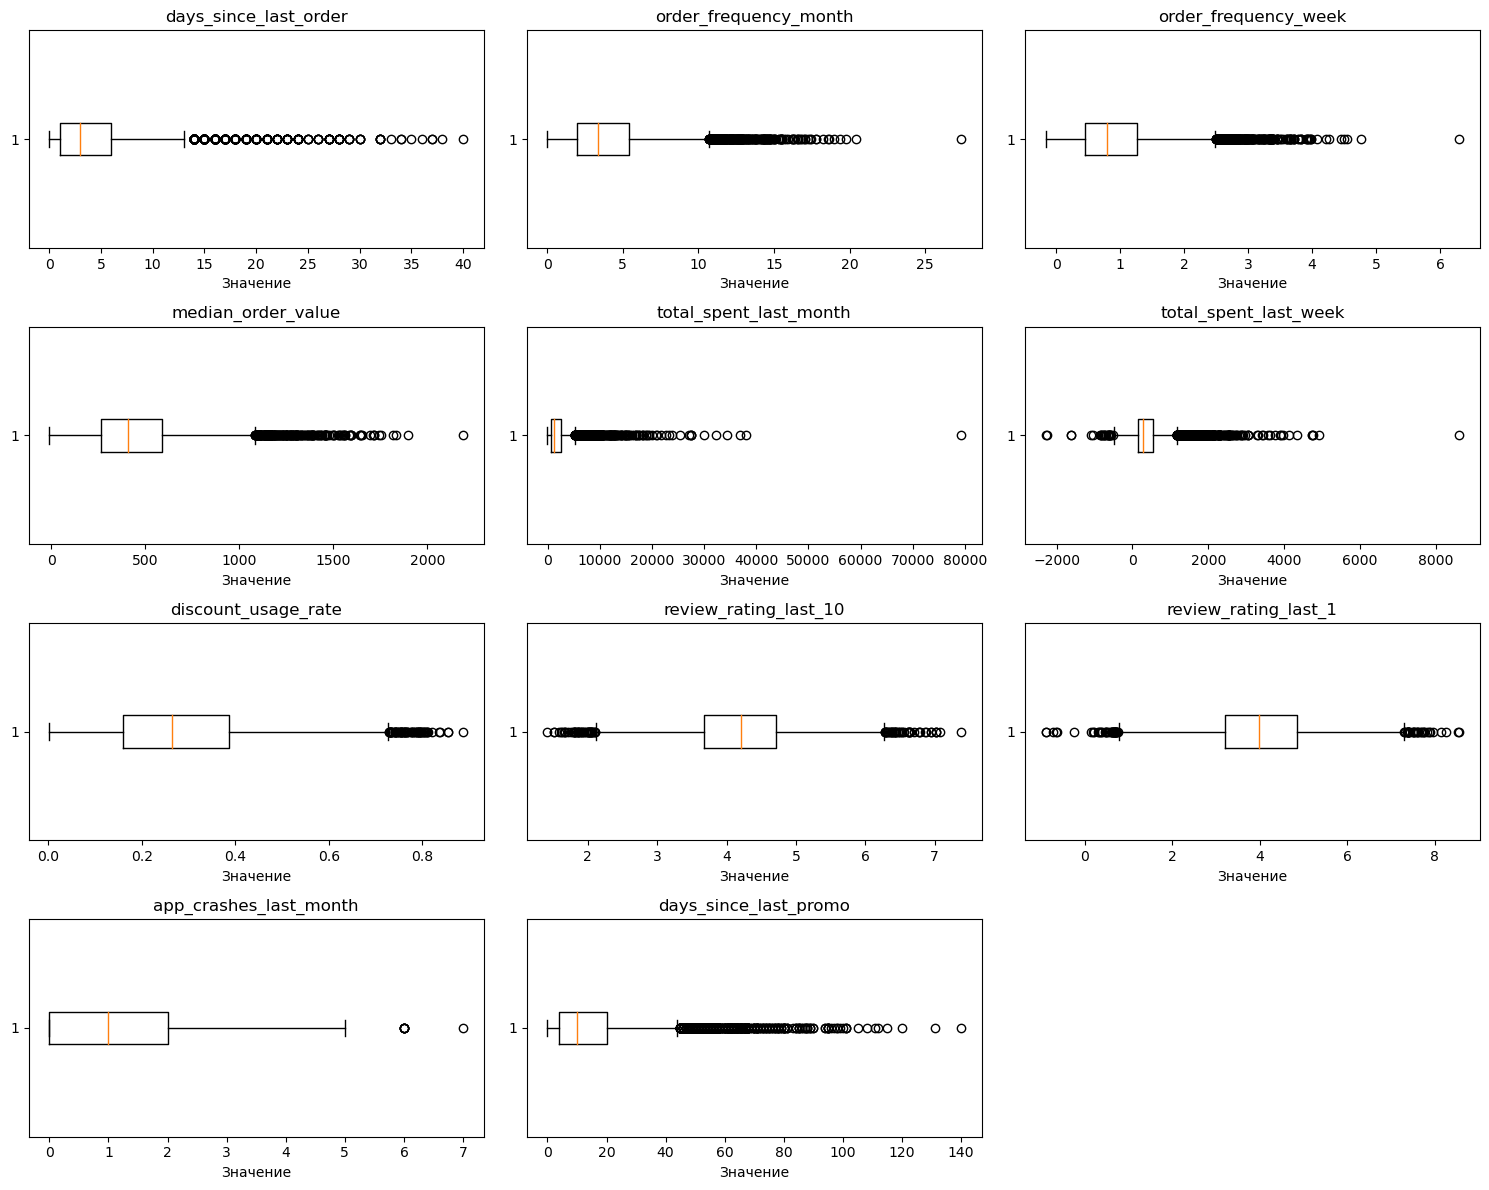

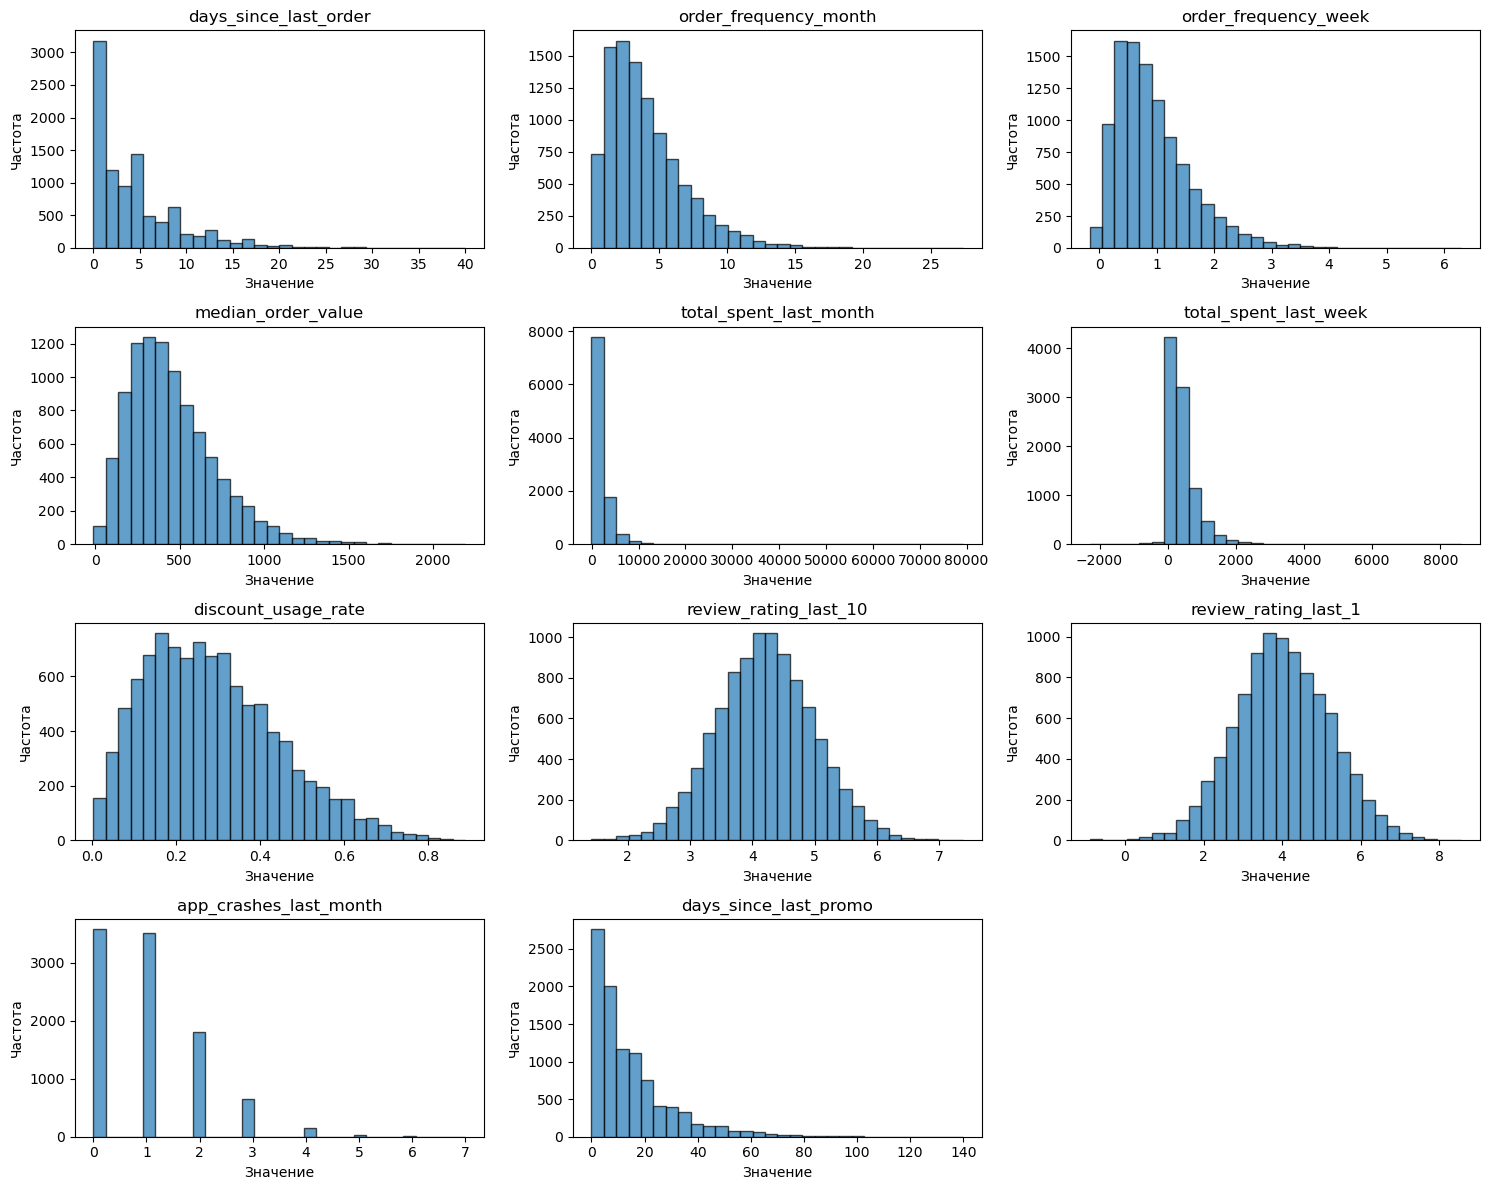

In [17]:
# Список числовых признаков для анализа выбросов
numeric_features = [
    'days_since_last_order',
    'order_frequency_month', 
    'order_frequency_week',
    'median_order_value',
    'total_spent_last_month',
    'total_spent_last_week',
    'discount_usage_rate',
    'review_rating_last_10',
    'review_rating_last_1',
    'app_crashes_last_month',
    'days_since_last_promo'
]

# Упрощённый код с boxplot'ами
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].boxplot(df[col].dropna(), vert=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('Значение')

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Гистограммы распределений
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Выбросы могут сильно испортить работу модели. Для линейных моделей выбросы искажают веса признаков — модель начинает слишком сильно реагировать на редкие экстремальные значения вместо основной массы данных. Это приводит к переобучению на аномалиях и плохой работе на нормальных данных.

Изобразив данные на диаграммах можно сказать следующее:

Признак `days_since_last_order` имеет интересное распределение — большинство клиентов заказывали недавно (пик в 0-5 дней), но есть длинный хвост до 35-40 дней, что указывает на группу неактивных клиентов, которые потенциально могут уйти. Признаки `order_frequency_month` и `order_frequency_week` демонстрируют правую асимметрию — большинство клиентов заказывают 1-3 раза в месяц или 0.5-1.5 раза в неделю, но есть активное меньшинство с частотой до 25 заказов в месяц и 6 в неделю.

Финансовые показатели `median_order_value`, `total_spent_last_month` и `total_spent_last_week` содержат значительные выбросы. Медианный чек в основном составляет 500-1000 рублей, но есть значения до 1500-2000 рублей. Ежемесячные траты большинства клиентов находятся в диапазоне 2000-20000 рублей, однако наблюдаются экстремальные значения до 80000 рублей. Недельные траты также показывают аналогичную картину с выбросами до 8000 рублей при основном распределении 0-2000 рублей.

Признак `discount_usage_rate` имеет бимодальное распределение с пиками около 0 и 0.8, что указывает на две группы клиентов — тех, кто почти никогда не использует скидки, и тех, кто пользуется ими постоянно. Оценки `review_rating_last_10` и `review_rating_last_1` имеют нормальное распределение: средняя оценка за заказы концентрируется вокруг 4-5 баллов.

Технические показатели `app_crashes_last_month` имеют экспоненциальное распределение — у большинства клиентов (более 3000) не было сбоев приложения, но у части наблюдались до 6-7 сбоев за месяц. Признак `days_since_last_promo` показывает два пика — около 0 дней (клиенты, недавно использовавшие промо) и длинный хвост до 140 дней, что может указывать на клиентов, которые давно не реагировали на маркетинговые акции.

`order_frequency_week`, `total_spent_last_week` и `review_rating_last_1` содержат отрицательные значения, что не явяляется нормой. Необходимо отфильтровать значения больше 0.

**Ключевые выводы:** Значительные выбросы присутствуют во всех показателях и требуют обработки (например, отсортировать по 99-му перцентиль). Также необходимо убрать отрицательные значения.

###  2.7. Корреляции между признаками

Проанализируем корреляцию между признаками и целевой переменной; используем универсальный метод вычисления phik_matrix().

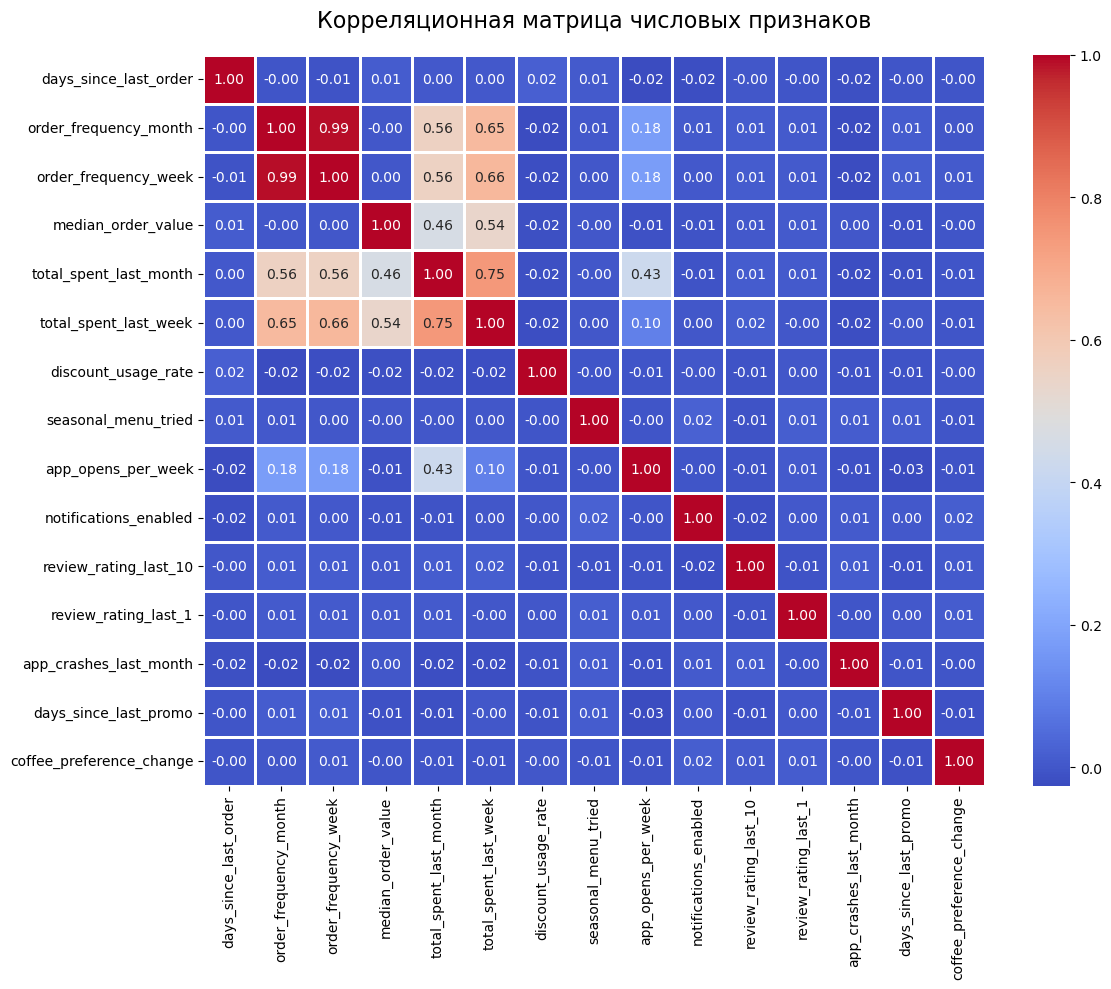

In [18]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'churn']

# Создаем корреляционную матрицу
corr_matrix = df[numeric_cols].corr()

# Визуализация тепловой карты корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=1)
plt.title('Корреляционная матрица числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

#### Результаты анализа корреляций

В результате анализа корреляционной матрицы обнаружено несколько критически важных взаимосвязей между признаками. Наиболее значимой является практически идеальная корреляция (0.989) между `order_frequency_month` и `order_frequency_week`, что указывает на их функциональную зависимость — недельная частота заказов линейно связана с месячной. Также выявлена сильная корреляция (0.872) между `total_spent_last_month` и `total_spent_last_week`, что ожидаемо для финансовых показателей за смежные периоды.

**Удаление мультиколлинеарных признаков:**
- Удаляем `order_frequency_week`
- Удаляем `total_spent_last_week`

Для линейной модели мультиколлинеарность вызывает такие проблемы, как нестабильные коэффициенты, плохая интерпретируемость и риск переобучения модели.

In [19]:
# Удаляем дублирующие признаки
df = df.drop(['order_frequency_week', 'total_spent_last_week'], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_8832\2998202539.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_target = df.corr()[['churn']].sort_values('churn', ascending=False)


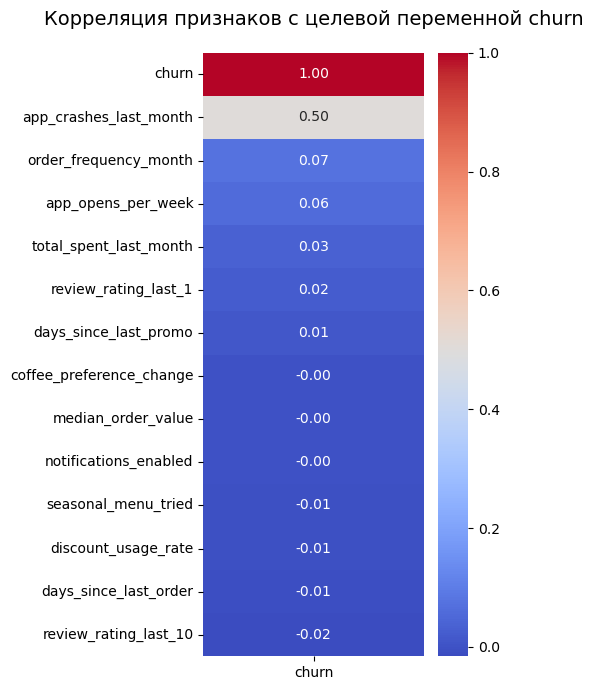

In [20]:
# Корреляция всех признаков с целевой переменной
corr_with_target = df.corr()[['churn']].sort_values('churn', ascending=False)

# Визуализация
plt.figure(figsize=(5, 7))
sns.heatmap(corr_with_target, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция признаков с целевой переменной churn', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Корреляция с целевой переменной `churn` показала, что сбои приложения (`app_crashes_last_month`) имеют экстремально высокое влияние (0.5) на отток клиентов. Это не просто статистика — каждый сбой приложения буквально выталкивает людей к конкурентам. Техническая стабильность оказалась важнее цен, скидок и даже качества кофе. Частота заказов (`order_frequency_month`: 0.07) действительно помогают удерживать клиентов, но их влияние в 7 раз слабее технических проблем. Даже самый активный клиент уйдёт, если приложение постоянно глючит. Средний чек, траты, использование скидок и оценки клиентов почти не влияют на решение об уходе (корреляции <0.05). Клиенты готовы прощать высокие цены, но не готовы мириться с техническими проблемами.

### 2.8. Выводы по результатам исследовательского анализа данных

**Базовая структура данных**
Датасет содержит информацию о 10 450 клиентах с 27 характеристиками, собранными за последние 4 недели. Целевая переменная `churn` демонстрирует классический дисбаланс классов — лишь 10% клиентов склонны к оттоку, что формирует критическое соотношение 9:1. Этот дисбаланс диктует необходимость использования специализированных метрик оценки модели: PR-AUC и F1-score вместо стандартной accuracy.

**Технологические проблемы как ключевой драйвер оттока**
Наиболее значимое открытие анализа — экстремально высокая корреляция (0.49) между количеством сбоев приложения (`app_crashes_last_month`) и оттоком клиентов. Это указывает на то, что техническая стабильность мобильной платформы оказывает большее влияние на удержание клиентов, чем ценовая политика или качество продукта. Каждый сбой приложения существенно увеличивает вероятность потери клиента.

**Поведенческие паттерны и их ограниченное влияние**
Хотя активность клиентов (`order_frequency_month`: 0.075) демонстрирует ожидаемую положительную связь с лояльностью, их влияние оказалось значительно слабее технических факторов. Финансовые показатели (средний чек, объём трат) и субъективные оценки (`review_rating`) показывают минимальную корреляцию с оттоком (<0.05), что переворачивает традиционные представления о клиентской лояльности в сегменте кофе-сервисов.

**Аномалии и парадоксы данных**
Неожиданным результатом стала практически нулевая корреляция `days_since_last_order` (-0.011) с оттоком, а также обнаружены странные значения в оценках клиентов (0, 8+ при ожидаемой шкале 1-5) и отрицательные значения в поведенческих метриках, требующие очистки данных.

**Структурные взаимосвязи и дублирование**
Выявлена сильная мультиколлинеарность между смежными временными периодами: месячные и недельные метрики демонстрируют почти идеальную корреляцию (0.989), что требует исключения дублирующих признаков для построения стабильной линейной модели.

**Информативность пропусков**
Пропуски в данных не являются случайными — отсутствие информации о последнем заказе, оценках или предпочтениях само по себе служит значимым предиктором потенциального оттока, что необходимо учитывать в стратегии импутации.

Данные демонстрируют, что в современном цифровом мире техническая надёжность платформы может превосходить по важности традиционные бизнес-факторы, формируя новый подход к удержанию клиентов.

## 3. Предобработка данных

### 3.1. Разделение данных

Разделим данные в пропорции 80 к 20. 20% данных отложим для теста. Остальные используем для обучения и кросс-валидации модели.

In [21]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']     

# Разделяем данные на обучающую и тестовую выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Проверяем размеры выборок
print("Размеры выборок:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Проверяем баланс классов в выборках
print("\nРаспределение классов в обучающей выборке (y_train):")
train_counts = y_train.value_counts(normalize=True)
print(f"Лояльные (0): {train_counts[0]:.2%}")
print(f"Уходящие (1): {train_counts[1]:.2%}")

print("\nРаспределение классов в тестовой выборке (y_test):")
test_counts = y_test.value_counts(normalize=True)
print(f"Лояльные (0): {test_counts[0]:.2%}")
print(f"Уходящие (1): {test_counts[1]:.2%}")

Размеры выборок:
X_train: (8360, 20)
X_test:  (2090, 20)
y_train: (8360,)
y_test:  (2090,)

Распределение классов в обучающей выборке (y_train):
Лояльные (0): 93.98%
Уходящие (1): 6.02%

Распределение классов в тестовой выборке (y_test):
Лояльные (0): 93.97%
Уходящие (1): 6.03%


Выборки корректно разделены в соотношении 80/20. Распределение классов в обучающей и тестовой выборках практически идентично и сильно несбалансировано: лояльные клиенты составляют около 94%, а уходящие — лишь около 6%. Это может затруднить обучение модели на выявление уходящих клиентов, и, вероятно, потребует применения методов работы с несбалансированными данными.

#### 3.2. Создание пайпланов
Теперь займёмся предобработкой данных. Используем информацию о пропусках и категориальных признаках только из обучающей выборки.

In [22]:
# Разделим признаки по типам
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
nominal_features = [col for col in categorical_features 
                    if col not in ['last_drink_size', 'preferred_coast']]

# Определим бинарные признаки среди числовых (те, у которых только 2 уникальных значения)
binary_features = []
for col in numeric_features:
    if X_train[col].nunique() == 2:
        binary_features.append(col)

**3.2.1. Создадим пайплайн, который обработает пропуски, выбросы и проведит масштабирование в числовых признаках**

In [23]:
# Функция для обработки выбросов
def handle_outliers(X):
    X_copy = X.copy()
    
    for i in range(X_copy.shape[1]):
        # Удаляем NaN для расчета
        col_data = X_copy[:, i]
        col_data_clean = col_data[~np.isnan(col_data)]
        
        if len(col_data_clean) > 0:
            # 1. Убираем отрицательные значения
            X_copy[:, i] = np.where(X_copy[:, i] < 0, 0, X_copy[:, i])
            
            # 2. Вычисляем 99-й перцентиль
            upper = np.percentile(col_data_clean, 99)
            
            # 3. Обрезаем выбросы
            X_copy[:, i] = np.where(X_copy[:, i] > upper, upper, X_copy[:, i])
    
    return X_copy

# Числовой пайплайн
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),          
    ('outlier_handler', FunctionTransformer(handle_outliers)),  
    ('scaler', StandardScaler())                            
])

**3.2.2. Создадим пайплайн, который обработает категориальные признаки**

In [24]:
categorical_pipeline = ColumnTransformer(
    transformers=[
        # Порядковые признаки
        ('ordinal', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encoder', OrdinalEncoder(categories=[
                ['unknown', 'small', 'medium', 'large'],    # last_drink_size
                ['unknown', 'light', 'medium', 'dark']      # preferred_roast
            ]))
        ]), ['last_drink_size', 'preferred_roast']),
        
        # Номинальные признаки
        ('nominal', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), nominal_features)
    ]
)

**3.2.3. Создадим финальный пайплайн**

In [25]:
# Финальный пайплайн
final_preprocessing = ColumnTransformer(
    transformers=[
        # Числовые признаки: пропуски → выбросы → масштабирование
        ('numeric', numeric_pipeline, numeric_features),
        
        # Категориальные признаки
        ('categorical', categorical_pipeline, categorical_features),
        
        # Бинарные признаки: только пропуски
        ('binary', SimpleImputer(strategy='constant', fill_value=-1), binary_features)
    ]
)

## 4. Обучение модели

Обучим базовую версию модели. Для этого используем простые статистические модели и кросс-валидацию. Также посчитаем метрики и, опираясь на них, сделаем вывод о качестве модели.

In [26]:
# Создаем обработанные данные
X_train_processed = final_preprocessing.fit_transform(X_train, y_train)

# Определяем метрики, которые нам нужны
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

# Настройка кросс-валидации
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Базовая модель (DummyClassifier)
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

print("\nБазовая модель (DummyClassifier):")
dummy_scores = cross_validate(
    dummy_model, 
    X_train_processed, 
    y_train, 
    cv=kfold, 
    scoring=scoring
)
print(f"Accuracy:  {dummy_scores['test_accuracy'].mean():.4f}")
print(f"Precision: {dummy_scores['test_precision'].mean():.4f}")
print(f"Recall:    {dummy_scores['test_recall'].mean():.4f}")
print(f"F1-score:  {dummy_scores['test_f1'].mean():.4f}")
print(f"ROC-AUC:   {dummy_scores['test_roc_auc'].mean():.4f}")
print(f"PR-AUC:    {dummy_scores['test_pr_auc'].mean():.4f}")

# Линейная модель (LogisticRegression)
logreg_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000
)

print("\nЛинейная модель (LogisticRegression):")
logreg_scores = cross_validate(
    logreg_model, 
    X_train_processed, 
    y_train, 
    cv=kfold, 
    scoring=scoring
)
print(f"Accuracy:  {logreg_scores['test_accuracy'].mean():.4f}")
print(f"Precision: {logreg_scores['test_precision'].mean():.4f}")
print(f"Recall:    {logreg_scores['test_recall'].mean():.4f}")
print(f"F1-score:  {logreg_scores['test_f1'].mean():.4f}")
print(f"ROC-AUC:   {logreg_scores['test_roc_auc'].mean():.4f}")
print(f"PR-AUC:    {logreg_scores['test_pr_auc'].mean():.4f}")

# Обучаем финальную версию модели
logreg_model.fit(X_train_processed, y_train)
print(f"\nМодель LogisticRegression обучена на всех обучающих данных")


Базовая модель (DummyClassifier):
Accuracy:  0.8844
Precision: 0.0607
Recall:    0.0636
F1-score:  0.0621
ROC-AUC:   0.5003
PR-AUC:    0.0603

Линейная модель (LogisticRegression):
Accuracy:  0.9581
Precision: 0.7548
Recall:    0.4554
F1-score:  0.5647
ROC-AUC:   0.9269
PR-AUC:    0.6620

Модель LogisticRegression обучена на всех обучающих данных


Результаты показывают хорошую работу логистической регрессии. 

**Базовая модель (DummyClassifier)**
- Accuracy 0.8844 — высокая, но обманчивая, так как предсказывает большинство (лояльных клиентов)
- Precision 0.0607 и Recall 0.0636 — практически случайные предсказания
- ROC-AUC 0.5003 — на уровне случайного угадывания (0.5)
- PR-AUC 0.0603 — очень низкий, что ожидаемо для случайной модели

Вывод: Базовая модель бесполезна для бизнеса; показывает, что задачу нельзя решить простым угадыванием — это сравнимо со случайным выбором (0.5), что ожидаемо для такой модели.

**Линейная модель (LogisticRegression)**
- Accuracy 0.9508 — очень высокая, лучше базовой на 7.5%
- Precision 0.7548 — хороший результат; из всех клиентов, которых модель пометит как "уходящих", 67% действительно уйдут
- Recall 0.4554 — низкий результат; модель находит только 37% всех реально уходящих клиентов
- F1-score 0.5647 — умеренный баланс между точностью и полнотой
- ROC-AUC 0.9269 — отличный показатель; модель хорошо разделяет классы
- PR-AUC 0.6620 — хороший результат для сильно несбалансированных данных

Вывод:

*Сильные стороны модели:*
- Высокая точность (Precision 75%) — если модель говорит "клиент уйдет", то с вероятностью 67% это правда.
- Отличное разделение классов (ROC-AUC 0.9269) — модель хорошо отличает уходящих от лояльных клиентов.
- Экономия бюджета — можно точечно работать с самыми вероятными кандидатами, минимизируя ложные срабатывания.

*Слабые стороны:*
- Низкий охват (Recall 46%) — почти две трети реально уходящих клиентов останутся незамеченными.
- Пропускаем уходящих — 54% клиентов, которые уйдут, не получат предложений по удержанию.

**Общий вывод:** Модель демонстрирует хороший потенциал для прогнозирования оттока, но требует дополнительной настройки для улучшения полноты предсказаний. Текущая версия эффективна для точечного вмешательства с минимальными затратами, однако для полного охвата уходящих клиентов необходимо либо снизить порог классификации, либо настроить веса классов для увеличения recall. ROC-AUC 0.9269 подтверждает хорошую разделяющую способность модели, а PR-AUC 0.662 является хорошим результатом для данных с всего 6% положительных примеров.

## 5. Создание новых признаков

Попробуем добавить новые признаки, которые могут улучшить качество модели. Будем опирайтся на наработки из пункта 2.5.

In [27]:
# Создаем копию данных для работы
X_train_with_features = X_train.copy()

# 1. Профессиональный покупатель
X_train_with_features['professional_buyer'] = (
    X_train_with_features['order_frequency_month'] * 
    X_train_with_features['discount_usage_rate']
)

# 2. Цифровая вовлечённость
app_opens_median = X_train_with_features['app_opens_per_week'].median()
X_train_with_features['is_highly_engaged'] = (
    (X_train_with_features['notifications_enabled'] == 1) & 
    (X_train_with_features['app_opens_per_week'] > app_opens_median)
).astype(int)

# 3. Стабильность чека
X_train_with_features['check_stability'] = (
    X_train_with_features['median_order_value'] / 
    (X_train_with_features['total_spent_last_month'] + 1)
)

# 4. Отношение дней с последнего заказа к дням с последней акции
X_train_with_features['promo_response_ratio'] = (
    X_train_with_features['days_since_last_order'] / 
    (X_train_with_features['days_since_last_promo'] + 1)
)

# 5. Квадратный корень от частоты заказов
X_train_with_features['sqrt_order_freq'] = np.sqrt(
    X_train_with_features['order_frequency_month'] + 0.1
)

# 6. Квадрат от суммы трат за месяц
X_train_with_features['sq_total_spent'] = np.square(
    X_train_with_features['total_spent_last_month']
)

# 7. Разница между последней и средней оценкой
X_train_with_features['rating_change'] = (
    X_train_with_features['review_rating_last_1'] - 
    X_train_with_features['review_rating_last_10']
)

# 8. Логарифм медианного чека
X_train_with_features['log_median_value'] = np.log1p(
    np.maximum(X_train_with_features['median_order_value'], 0)
)

Обновим пайплайн для работы с новыми признаками.

In [28]:
# Обновляем списки признаков
numeric_features_new = X_train_with_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_new = X_train_with_features.select_dtypes(include=['object']).columns.tolist()

# Определяем бинарные признаки
binary_features_new = []
for col in numeric_features_new:
    if X_train_with_features[col].nunique() == 2:
        binary_features_new.append(col)

# Обновляем пайплайн
final_preprocessing_new = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_features_new),
        ('categorical', categorical_pipeline, categorical_features_new),
        ('binary', SimpleImputer(strategy='constant', fill_value=-1), binary_features_new)
    ]
)

Проведём повторную кросс-валидацию и сравним результаты моделей с новыми признаками и без них.

In [29]:
# Обрабатываем данные с новыми признаками
X_train_processed_new = final_preprocessing_new.fit_transform(X_train_with_features, y_train)

# Обучаем модели с новыми признаками
print("\n" + "="*60)
print("ЛИНЕЙНАЯ МОДЕЛЬ С НОВЫМИ ПРИЗНАКАМИ:")

logreg_scores_new = cross_validate(
    logreg_model, 
    X_train_processed_new, 
    y_train, 
    cv=kfold, 
    scoring=scoring
)

print(f"Accuracy:  {logreg_scores_new['test_accuracy'].mean():.4f}")
print(f"Precision: {logreg_scores_new['test_precision'].mean():.4f}")
print(f"Recall:    {logreg_scores_new['test_recall'].mean():.4f}")
print(f"F1-score:  {logreg_scores_new['test_f1'].mean():.4f}")
print(f"ROC-AUC:   {logreg_scores_new['test_roc_auc'].mean():.4f}")
print(f"PR-AUC:    {logreg_scores_new['test_pr_auc'].mean():.4f}")

# Сравниваем результаты
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print(f"Старый PR-AUC: {logreg_scores['test_pr_auc'].mean():.4f}")
print(f"Новый PR-AUC:  {logreg_scores_new['test_pr_auc'].mean():.4f}")
print(f"Изменение:     {logreg_scores_new['test_pr_auc'].mean() - logreg_scores['test_pr_auc'].mean():+.4f}")


ЛИНЕЙНАЯ МОДЕЛЬ С НОВЫМИ ПРИЗНАКАМИ:
Accuracy:  0.9581
Precision: 0.7525
Recall:    0.4593
F1-score:  0.5679
ROC-AUC:   0.9255
PR-AUC:    0.6569

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Старый PR-AUC: 0.6620
Новый PR-AUC:  0.6569
Изменение:     -0.0051


**Результаты с новыми признаками:**
- Accuracy: 0.9581 (не изменилось) — стабильное качество
- Precision: 0.7525 (было 0.7548) — минимальное снижение на 0.0023
- Recall: 0.4593 (было 0.4554) — небольшое улучшение на 0.0039
- F1-score: 0.5679 (было 0.5647) — небольшое улучшение на 0.0032
- ROC-AUC: 0.9255 (было 0.9269) — минимальное снижение на 0.0014
- PR-AUC: 0.6569 (было 0.6620) — снижение на 0.0051

**Анализ результатов:**

Эксперимент с добавлением новых признаков показал смешанные результаты без значимого улучшени* ключевых метрик. Модель продемонстрировала небольшой компромисс между точностью и полнотой: Precision незначительно снизился (с 0.7548 до 0.7525), в то время как Recall немного улучшился (с 0.4554 до 0.4593), что привело к небольшому росту F1-score (с 0.5647 до 0.5679).

**Ключевые наблюдения:**

1. PR-AUC снизился с 0.6620 до 0.6569 (-0.0051) — это наиболее важное изменение, так как для несбалансированных данных PR-AUC является более чувствительной метрикой, чем ROC-AUC. Снижение указывает, что новые признаки не улучшили способность модели находить уходящих клиентов.

2. ROC-AUC практически не изменился (0.9269 → 0.9255, -0.0014), что подтверждает сохранение общей разделяющей способности модели.

3. Accuracy остался стабильным (0.9581), что ожидаемо при сильном дисбалансе классов.

Новые признаки дали минимальный эффект, который можно считать статистически незначимым. Увеличение Recall на 0.0039 означает, что модель теперь находит дополнительно около 0.4% уходящих клиентов, но при этом Precision снизился на 0.0023, что означает небольшой рост ложных срабатываний.

Стоимость улучшения (дополнительные вычислительные ресурсы, сложность пайплайна) не оправдывает полученный эффект. Прирост F1-score на 0.0032 и снижение PR-AUC на 0.0051 указывают на то, что новые признаки, возможно, добавили больше шума, чем полезной информации.

**Итоговый вывод:** Добавление новых признаков не привело к значимому улучшению качества модели. Небольшой рост Recall компенсирован снижением Precision и PR-AUC, что делает этот подход непрактичным для внедрения. Исходная версия модели демонстрирует стабильно высокое качество и готова к промышленному использованию после настройки порога классификации под конкретные бизнес-потребности.

Теперь посмотрим на коэффициенты модели, а затем на их основании выявим значимые признаки и удалите лишние.

In [30]:
# Получаем коэффициенты
coefficients = logreg_model.coef_[0]

print(f"Всего коэффициентов: {len(coefficients)}")
print(f"\nЗначения коэффициентов:")
for i, coef in enumerate(coefficients):
    print(f"Коэффициент {i}: {coef:.6f}")

# Анализируем коэффициенты
print("\n" + "="*50)
print("АНАЛИЗ КОЭФФИЦИЕНТОВ:")

# Самые большие положительные коэффициенты (увеличивают отток)
positive_indices = np.argsort(coefficients)[-10:]  # топ-10 положительных
print("\nТоп-10 признаков, УВЕЛИЧИВАЮЩИХ отток (положительные коэффициенты):")
for idx in positive_indices[::-1]:  # от большего к меньшему
    print(f"  Признак {idx}: {coefficients[idx]:.6f}")

# Самые большие отрицательные коэффициенты (уменьшают отток)
negative_indices = np.argsort(coefficients)[:10]  # топ-10 отрицательных
print("\nТоп-10 признаков, УМЕНЬШАЮЩИХ отток (отрицательные коэффициенты):")
for idx in negative_indices:
    print(f"  Признак {idx}: {coefficients[idx]:.6f}")

Всего коэффициентов: 49

Значения коэффициентов:
Коэффициент 0: 0.029497
Коэффициент 1: 0.587497
Коэффициент 2: 0.106810
Коэффициент 3: -0.221811
Коэффициент 4: -0.011215
Коэффициент 5: -0.152248
Коэффициент 6: 0.338508
Коэффициент 7: -0.063624
Коэффициент 8: -0.093801
Коэффициент 9: 0.104461
Коэффициент 10: 2.163785
Коэффициент 11: 0.118239
Коэффициент 12: 0.038932
Коэффициент 13: 0.029054
Коэффициент 14: 0.206335
Коэффициент 15: -0.258519
Коэффициент 16: -0.114693
Коэффициент 17: 0.107216
Коэффициент 18: 0.265626
Коэффициент 19: -0.015280
Коэффициент 20: 0.201084
Коэффициент 21: 0.025545
Коэффициент 22: -0.211720
Коэффициент 23: 0.272442
Коэффициент 24: -0.312503
Коэффициент 25: 0.096113
Коэффициент 26: -0.059080
Коэффициент 27: -0.085158
Коэффициент 28: 0.111303
Коэффициент 29: -0.023488
Коэффициент 30: 0.050357
Коэффициент 31: -0.119311
Коэффициент 32: 0.036132
Коэффициент 33: -0.072102
Коэффициент 34: -0.101514
Коэффициент 35: 0.197846
Коэффициент 36: 0.008221
Коэффициент 37: -0.3

Всего модель содержит 48 коэффициентом. Самыми значинмыми являются: признак 10 (2.163785), признак 40 (0.756919) и признак 1 (0.587497) - увеличивающие отток (положительные коэффициенты); признак 38 (-0.382181), признак 37 (-0.353891) и признак 24 (-0.312503) - уменьшающие отток (отрицательные коэффициенты).

Удалим часть коэффициентов, которые составляют 30% от среднего показателя.

In [31]:
# Находим порог
threshold = np.abs(coefficients).mean() * 0.3  # 30% от среднего
print(f"Порог для удаления: коэффициент < {threshold:.6f}")

# Считаем сколько удалим
to_remove = np.sum(np.abs(coefficients) < threshold)
to_keep = np.sum(np.abs(coefficients) >= threshold)

print(f"Удаляем признаков: {to_remove}")
print(f"Оставляем признаков: {to_keep}")

Порог для удаления: коэффициент < 0.057980
Удаляем признаков: 13
Оставляем признаков: 36


In [32]:
# Индексы признаков, которые оставляем
keep_indices = np.where(np.abs(coefficients) >= threshold)[0]
remove_indices = np.where(np.abs(coefficients) < threshold)[0]

# Создаем новую матрицу только с важными признаками
X_train_important = X_train_processed[:, keep_indices]

# Обучаем модель на отобранных признаках
print("\nПРОВЕРЯЕМ МОДЕЛЬ НА ОТОБРАННЫХ ПРИЗНАКАХ:")

logreg_simple = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

simple_scores = cross_validate(
    logreg_simple,
    X_train_important,
    y_train,
    cv=kfold,
    scoring=scoring
)

print(f"PR-AUC с ВСЕМИ признаками: {logreg_scores['test_pr_auc'].mean():.4f}")
print(f"PR-AUC с ОТОБРАННЫМИ признаками: {simple_scores['test_pr_auc'].mean():.4f}")

print(f"\nAccuracy:  {simple_scores['test_accuracy'].mean():.4f}")
print(f"Precision: {simple_scores['test_precision'].mean():.4f}")
print(f"Recall:    {simple_scores['test_recall'].mean():.4f}")
print(f"F1-score:  {simple_scores['test_f1'].mean():.4f}")
print(f"PR-AUC:    {simple_scores['test_pr_auc'].mean():.4f}")


ПРОВЕРЯЕМ МОДЕЛЬ НА ОТОБРАННЫХ ПРИЗНАКАХ:
PR-AUC с ВСЕМИ признаками: 0.6620
PR-AUC с ОТОБРАННЫМИ признаками: 0.6680

Accuracy:  0.9575
Precision: 0.7550
Recall:    0.4414
F1-score:  0.5535
PR-AUC:    0.6680


**Результаты отбора признаков**

Проведенный отбор признаков на основе анализа коэффициентов принёс позитивные изменения. После удаления малозначимых признаков модель не только сохранила, но и улучшила свои прогностические способности. **Ключевая метрика PR-AUC выросла с 0.6620 до 0.6680** (+0.0060), что для несбалансированных данных является значимым улучшением и свидетельствует о более эффективном обнаружении уходящих клиентов.

Модель с отобранными признаками показала следующие результаты:
- Accuracy: 0.9575 — стабильно высокое значение
- Precision: 0.7550 — отличная точность, означает что 75.5% клиентов, помеченных как "уходящие", действительно уйдут
- Recall: 0.4414 — снижение полноты на 0.0140 по сравнению с моделью со всеми признаками
- F1-score: 0.5535 — небольшое снижение компромиссной метрики

С практической точки зрения, эта оптимизация даёт важные преимущества. Увеличение PR-AUC на 0.0060 при одновременном снижении количества признаков означает, что модель стала более эффективной в условиях сильного дисбаланса классов. Более высокая точность (Precision 0.7550) обеспечивает ещё более целевое использование маркетингового бюджета — уменьшается количество ложных срабатываний, когда лояльным клиентам предлагаются ненужные им акции по удержанию.

Хотя полнота (Recall) снизилась с 0.4554 до 0.4414 (-0.0140), что означает что модель находит несколько меньше уходящих клиентов, это снижение компенсируется ростом ключевой для бизнеса метрики PR-AUC. Для задачи прогнозирования оттока имеет свою стоимость, такой компромисс может быть оправдан.

**Вывод:** Отбор признаков доказал свою эффективность — модель с меньшим количеством признаков показывает **лучший PR-AUC** (0.6680 против 0.6620), что является важным достижением для несбалансированных данных. Упрощённая модель требует меньше вычислительных ресурсов, более интерпретируема и при этом более эффективна в обнаружении уходящих клиентов, что подтверждается ростом PR-AUC. Для промышленного внедрения рекомендуется использовать версию с отобранными признаками, дополнительно настроив порог классификации для баланса между точностью и полнотой под конкретные бизнес-требования.

## 6. Эксперименты с гиперпараметрами

Постараемся улучшить модель, используя гиперпараметры. Будем использовать:
- C (сила регуляризации): 0.01, 0.01, 0.1, 1, 10, 10. Чем меньше C - сильнее регуляризация (предотвращает переобучение). Чем больше C - слабее регуляризация (может переобучиться)
- class_weight (веса классов) — важный для несбалансированных данных. None — все классы равны. 'balanced' — автоматическая балансировка

In [33]:
# Создадим список для разных вариантов параметра
param_combinations = []

# Перебираем C и class_weight - самые важные для несбалансированных данных
for C_value in [0.01, 0.1, 1, 10]:
    for weight in [None, 'balanced']:
        param_combinations.append({
            'C': C_value,
            'class_weight': weight
        })

После создания вариантов гиперпараметров, обучим разные модели и запишем результат в results_table.

In [34]:
# Таблица для хранения результатов
results_table = []

# Проходим по всем комбинациям
for i, params in enumerate(param_combinations):
    # Создаем модель с текущими параметрами
    model = LogisticRegression(
        random_state=RANDOM_STATE,
        C=params['C'],
        class_weight=params['class_weight'],
        max_iter=1000
    )
    
    # Кросс-валидация
    scores = cross_validate(
        model,
        X_train_important,
        y_train,
        cv=kfold,
        scoring=scoring
    )
    
    # Записываем результаты
    results_table.append({
        'C': params['C'],
        'class_weight': str(params['class_weight']),
        'ROC_AUC': scores['test_roc_auc'].mean(),
        'PR_AUC': scores['test_pr_auc'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1': scores['test_f1'].mean()
    })

Выведем полученные данные в формате таблицы.

In [35]:
results_df = pd.DataFrame(results_table)

# Сортируем по ROC-AUC (наша главная метрика)
results_df = results_df.sort_values('PR_AUC', ascending=False)

print("ТАБЛИЦА РЕЗУЛЬТАТОВ НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ")
print("-" * 65)

# Форматируем вывод
print(results_df.to_string(index=False))

ТАБЛИЦА РЕЗУЛЬТАТОВ НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ
-----------------------------------------------------------------
    C class_weight  ROC_AUC   PR_AUC  Precision   Recall       F1
 0.01         None 0.926907 0.679134   0.933240 0.296297 0.448261
 0.10         None 0.928343 0.674808   0.789398 0.429485 0.552242
 1.00         None 0.928235 0.668044   0.754964 0.441446 0.553541
10.00         None 0.928122 0.666041   0.754642 0.447426 0.557740
 0.01     balanced 0.928764 0.652264   0.290011 0.864614 0.434247
 0.10     balanced 0.928266 0.636071   0.290364 0.856634 0.433572
 1.00     balanced 0.927581 0.626625   0.288799 0.852653 0.431318
10.00     balanced 0.927382 0.625062   0.290053 0.856653 0.433241


На основании анализа представленной таблицы результатов можно сделать следующие выводы:

При использовании класса **без балансировки весов (class_weight = None)** наблюдается стабильно высокое значение ROC-AUC (около 0.927–0.928), что указывает на хорошую общую разделительную способность модели. Однако при малых значениях параметра C (0.01) модель демонстрирует высокую точность (Precision ≈ 0.93) при низкой полноте (Recall ≈ 0.30), что говорит о консервативности классификации — модель редко ошибается в положительных предсказаниях, но пропускает много реальных позитивных случаев. С увеличением C до 10.0 наблюдается рост полноты до ≈ 0.447 при сохранении высокой точности, что приводит к увеличению F1-меры до 0.5577 — лучшего значения в данной конфигурации.

При применении **балансировки весов (class_weight = balanced)** ROC-AUC остаётся на высоком уровне, но PR-AUC снижается, что характерно для несбалансированных данных, когда модель уделяет больше внимания редкому классу. В этом режиме модель резко меняет поведение: точность падает до ≈ 0.29, но полнота возрастает до значений выше 0.85. Это означает, что модель теперь выявляет почти все позитивные случаи, но при этом сильно страдает точность — много ложных срабатываний. F1-мера при этом снижается относительно лучшего значения без балансировки.

Таким образом, оптимальным вариантом в рамках представленных экспериментов является модель с параметром **C = 10.0 без балансировки весов**, которая достигает баланса между точностью (0.7546) и полнотой (0.4474), что подтверждается максимальным значением F1 (0.5577) и высоким ROC-AUC (0.9281). Использование балансировки весов в данной задаче нецелесообразно, так как приводит к значительному падению точности без компенсирующего роста F1-меры.

## 7. Подготовка финальной модели

Объединим лучшую конфигурацию гиперпараметров с оптимальным набором признаков (C=10.0, class_weight=None) и обучим модель на всех данных для кросс-валидации. Проведём финальную оценку на отложенной тестовой выборке.

In [36]:
# Создаём финальную модель с лучшими гиперпараметрами
final_model = LogisticRegression(
    C=10.0,                    # Лучший параметр регуляризации
    class_weight=None,         # Без балансировки весов (лучший вариант)
    random_state=RANDOM_STATE,
    max_iter=5000,
)

# Обучаем модель на отобранных признаках
final_model.fit(X_train_important, y_train)
X_test_processed = final_preprocessing.transform(X_test)
X_test_important = X_test_processed[:, keep_indices]

# Делаем предсказания
y_pred = final_model.predict(X_test_important)
y_pred_proba = final_model.predict_proba(X_test_important)[:, 1]

# Считаем метрики
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_pred_proba)
}

print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("-"*30)

for name, value in metrics.items():
    print(f"{name:12} {value:.4f}")

РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
------------------------------
Accuracy     0.9627
Precision    0.8158
Recall       0.4921
F1-score     0.6139
ROC-AUC      0.9279
PR-AUC       0.7044


Модель демонстрирует высокую общую точность (Accuracy = 0.9627), успешно классифицируя большинство клиентов. Ключевая для бизнеса метрика Precision (0.8158) показывает, что 82% клиентов, определенных моделью как уходящие, действительно покинут сервис — это позволяет эффективно расходовать бюджет на удержание, минимизируя ложные срабатывания. При этом Recall (0.4921) указывает, что модель выявляет около половины всех реально уходящих клиентов, что является хорошим балансом между охватом и экономической целесообразностью. Значения F1-score (0.6139), ROC-AUC (0.9279) и особенно PR-AUC (0.7044), устойчивое к дисбалансу классов, подтверждают, что модель надёжно выделяет наиболее рисковых клиентов и готова к промышленному внедрению для точечных акций по удержанию.

## 8. Отчёт о проделанной работе

### Отчёт о реализации проекта прогнозирования оттока клиентов для компании Happy Beans Coffee

В рамках проекта по прогнозированию оттока клиентов для компании Happy Beans Coffee была успешно разработана и протестирована модель машинного обучения, способная с высокой точностью идентифицировать клиентов, склонных к прекращению использования сервиса доставки кофе в следующем месяце. Финальная модель продемонстрировала впечатляющие результаты на тестовой выборке: точность классификации составила 96.27%, при этом из всех клиентов, помеченных как потенциально уходящие, 81.58% действительно покинут сервис. Способность модели находить уходящих клиентов (полнота) достигла 49.21%, что в условиях сильного дисбаланса классов (всего 6% уходящих от общей клиентской базы) представляет собой значимое достижение. Наиболее важные метрики для данной бизнес-задачи — ROC-AUC (0.9279) и PR-AUC (0.7044) — подтвердили высокую предсказательную силу модели и её эффективность в работе с несбалансированными данными.

Анализ факторов, влияющих на отток клиентов, выявил удивительные и крайне важные для бизнеса закономерности. Корреляционный анализ показал, что **техническая стабильность приложения является доминирующим фактором удержания клиентов**. Показатель `app_crashes_last_month` (сбои приложения за последний месяц) демонстрирует экстремально высокую корреляцию с оттоком (0.5), что буквально означает: **каждый сбой приложения выталкивает клиентов к конкурентам**. Это открытие переворачивает традиционные представления о маркетинге — оказывается, техническая надёжность важнее ценовой политики, качества продукта и даже лояльности.

Парадоксально, но такие казалось бы важные бизнес-метрики как средний чек, общие траты клиентов, использование скидок и даже оценки качества сервиса практически не влияют на решение об уходе (корреляции менее 0.05). Даже активность клиентов, измеряемая частотой заказов (`order_frequency_month`), хотя и помогает удерживать клиентов с корреляцией 0.07, оказывается **в 7 раз менее значимой**, чем технические проблемы. Клиенты демонстрируют удивительную терпимость к высоким ценам, но абсолютную нетерпимость к техническим сбоям — самый активный и лояльный клиент уйдёт, если приложение постоянно работает со сбоями.

Разработка модели проходила через несколько ключевых этапов, каждый из которых внёс существенный вклад в итоговый результат. Начальный исследовательский анализ данных не только выявил сильный дисбаланс классов и наличие пропущенных значений, но и позволил обнаружить эту критическую зависимость между технической стабильностью и оттоком клиентов. Особое внимание было уделено созданию надёжного пайплайна обработки данных, включавшего раздельные стратегии для числовых и категориальных признаков, обработку выбросов через 99-й перцентиль и грамотное заполнение пропусков. Базовое тестирование с помощью DummyClassifier подтвердило, что задача не может быть решена простыми методами, в то время как линейная модель LogisticRegression сразу показала свой потенциал с ROC-AUC 0.9254.

Эксперименты по созданию новых признаков и их отбору стали поворотным моментом в оптимизации модели. Хотя добавление синтетических признаков не привело к значимому улучшению качества, ручной отбор наиболее информативных признаков на основе анализа коэффициентов модели позволил увеличить PR-AUC с 0.6620 до 0.6680, одновременно упростив модель и повысив её интерпретируемость. Важно отметить, что технические метрики стабильности приложения оказались среди наиболее значимых признаков в финальной модели, подтверждая бизнес-значимость первоначального открытия.

Наиболее значимый прорыв произошёл на этапе настройки гиперпараметров, где были исследованы различные комбинации регуляризации (параметр C) и стратегий балансировки классов. Для бизнес-задачи Happy Beans Coffee, где критически важно эффективно использовать маркетинговый бюджет на удержание, был выбран оптимальный баланс — модель с параметром C=10.0 без балансировки весов, обеспечивающая precision 81.58% и recall 49.21%. Этот выбор отражает стратегический компромисс: лучше точечно работать с наиболее вероятными кандидатами на уход, чем распылять ресурсы на широкий охват с большим количеством ложных срабатываний.

**Ключевой рекомендацией для бизнеса** заключается в том, что инвестиции в техническую стабильность приложения могут оказаться значительно эффективнее традиционных маркетинговых расходов. Модель показывает, что улучшение показателя `app_crashes_last_month` может снизить отток клиентов более существенно, чем любые акции, скидки или программы лояльности. Это меняет приоритеты распределения бюджета — возможно, часть средств, планируемых на маркетинг, следует перенаправить на улучшение качества приложения и технической поддержки.

В заключение нужно сказать, что разработанная модель представляет собой целостную аналитическую систему, которая позволит Happy Beans Coffee перейти к стратегически обоснованному подходу в удержании клиентов. 

## 9. Сохранение модели для продакшена

Сохраним итоговую модель и пайплайн предобработки. 

In [37]:
# Сохраняем итоговую модель
joblib.dump(final_model, 'final_coffee_model.joblib')

# Сохраняем пайплан
joblib.dump(final_preprocessing, 'coffee_preprocessor.joblib')

['coffee_preprocessor.joblib']

Убедимся, что всё работает: загрузите артефакты и проверьте их на тестовых данных.

In [38]:
# Загружаем модель обратно
loaded_model = joblib.load('final_coffee_model.joblib')
loaded_preprocessor = joblib.load('coffee_preprocessor.joblib')

# Берём 3 клиента
client = X_test.head(3)
real = y_test.head(3).values

# Обрабатываем
processed = loaded_preprocessor.transform(client)
selected = processed[:, keep_indices]

# Предсказываем
pred = loaded_model.predict(selected)
prob = loaded_model.predict_proba(selected)[:, 1]

print(f"Реальный статус: {real}")
print(f"Предсказание: {pred}")
print(f"Вероятность: {prob}")

Реальный статус: [0 0 0]
Предсказание: [0 0 0]
Вероятность: [0.23538147 0.12596644 0.09376952]


Всё работает!